In [1]:
#import necessary modules
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from Metadataload import metadataload
from revdataload import reviewsdataload
metadf= metadataload()
reviewdf= reviewsdataload()


In [3]:
from pyspark.sql.functions import count

def group_by_count(metadf, group_col, count_col):
    """
    Groups by a specified column and counts the number of occurrences of another column
    :param df: Spark DataFrame
    :param group_col: Column name to group by
    :param count_col: Column name to count
    :return: Grouped Spark DataFrame
    """
    grouped_df = metadf.groupBy(group_col).agg(count(count_col).alias('count'))
    return grouped_df

In [4]:
#Group wise count including null count
grouped_df = group_by_count(metadf, 'groups', 'id')
grouped_df.show()

+------+-----+
|groups|count|
+------+-----+
|      |   25|
|  Book| 1048|
| Music|  284|
| Video|   75|
|   DVD|   47|
|   Toy|    1|
+------+-----+



In [8]:
from pyspark.sql.functions import count, round, mean, stddev, min, max

# Function to calculate metadata for a column
def get_metadata(metadf, col_name):
    # Count of non-null values
    # count_ = metadf.select(count(col_name)).first()[0]
    count_ = metadf.filter(col(col_name).isNotNull()).count()
    # Count of null values
    null_count = metadf.filter(metadf[col_name].isNull()).count()
    # Count of distinct values
    distinct_count = metadf.select(col_name).distinct().count()
    # Fill rate percentage
    if null_count == 0:
        fill_rate = 100.0
    else:
        fill_rate = ((count_ / (count_ + null_count)) * 100, 2)
    # Count of distinct values after removing null values
    distinct_count_ = metadf.select(col_name).na.drop().distinct().count()
    # Most frequent values and their counts
    most_freq_values = metadf.groupBy(col_name).count().orderBy("count", ascending=False).limit(10).collect()
    most_freq_values_top_10 = [(row[col_name], row['count']) for row in most_freq_values]
    # Dataset size
    dataset_size = metadf.count()
    # Sample size and percentage
    sample_size = metadf.sample(False, 0.1).count()
    # sample_perc = round((sample_size / dataset_size) * 100, 2)
    # sample_perc = ((lit(sample_size) / dataset_size) * 100, 2).cast(DoubleType())

    # Mean, standard deviation, min, 25%, 50%, 75%, and max
    mean_ = metadf.select(mean(col_name)).first()[0]
    stddev_ = metadf.select(stddev(col_name)).first()[0]
    min_ = metadf.select(min(col_name)).first()[0]
    q1 = metadf.approxQuantile(col_name, [0.25], 0.01)[0]
    q2 = metadf.approxQuantile(col_name, [0.50], 0.01)[0]
    q3 = metadf.approxQuantile(col_name, [0.75], 0.01)[0]
    max_ = metadf.select(max(col_name)).first()[0]
    
    # Column sparsity
    col_sparsity = ((null_count / dataset_size) * 100, 2)
    
    # Create metadata tuple for the column
    metadata = (col_name,
                metadf.schema[col_name].dataType.simpleString(),
                count_,
                col_sparsity,
                distinct_count,
                fill_rate,
                distinct_count_,
                most_freq_values_top_10,
                dataset_size,
                sample_size,
                mean_,
                stddev_,
                min_,
                q1,
                q2,
                q3,
                max_)
    return metadata

# List of columns to get metadata for
columns = ['salesranks', 'total_reviews', 'avg_rating']

# Create a list of metadata tuples for all columns
metadata_list = [get_metadata(metadf, col) for col in columns]
print(metadata_list)

[('salesranks', 'double', 1466, (2.2666666666666666, 2), 1467, (97.73333333333333, 2), 1466, [(None, 34), (2895088.0, 1), (654748.0, 1), (48408.0, 1), (13524.0, 1), (110723.0, 1), (505266.0, 1), (1091842.0, 1), (161879.0, 1), (251469.0, 1)], 1500, 142, 486952.3894952251, 562817.0939726039, 19.0, 89264.0, 282822.0, 651510.0, 3459764.0), ('total_reviews', 'int', 1467, (2.1999999999999997, 2), 110, (97.8, 2), 109, [(0, 379), (1, 214), (2, 161), (3, 91), (4, 84), (5, 62), (7, 46), (8, 33), (None, 33), (6, 32)], 1500, 145, 17.552828902522155, 111.75350071507252, 0, 0.0, 2.0, 8.0, 3049), ('avg_rating', 'float', 1467, (2.1999999999999997, 2), 11, (97.8, 2), 10, [(0.0, 379), (5.0, 370), (4.5, 291), (4.0, 227), (3.5, 109), (3.0, 58), (None, 33), (2.5, 15), (2.0, 8), (1.0, 7)], 1500, 151, 3.1956373551465576, 1.9874009845298772, 0.0, 0.0, 4.0, 4.5, 5.0)]


In [ ]:
import pandas as pd

# Create a list of column names
columns = ['col_name', 'data_type', 'count', 'col_sparsity', 'distinct_count', 'fill_rate', 
           'distinct_count_', 'most_freq_values_top_10', 'dataset_size', 'sample_size', 'mean', 
           'stddev', 'min', 'q1', 'q2', 'q3', 'max']

# Create an empty DataFrame with the specified columns
df = pd.DataFrame(columns=columns)

# Loop over the tuple and append each row to the DataFrame
for tup in metadata_list:
    row = {
        'col_name': tup[0],
        'data_type': tup[1],
        'count': tup[2],
        'col_sparsity': tup[3][0],
        'distinct_count': tup[4],
        'fill_rate': tup[5][0],
        'distinct_count_': tup[6],
        'most_freq_values_top_10': tup[7],
        'dataset_size': tup[8],
        'sample_size': tup[9],
        'mean': tup[10],
        'stddev': tup[11],
        'min': tup[12],
        'q1': tup[13],
        'q2': tup[14],
        'q3': tup[15],
        'max': tup[16]
    }
    df = df.append(row, ignore_index=True)

# Print the resulting DataFrame
print(df)


        col_name data_type count  col_sparsity distinct_count  fill_rate  \
0     salesranks    double  1466      2.266667           1467  97.733333   
1  total_reviews       int  1467      2.200000            110  97.800000   
2     avg_rating     float  1467      2.200000             11  97.800000   

  distinct_count_                            most_freq_values_top_10  \
0            1466  [(None, 34), (2895088.0, 1), (654748.0, 1), (4...   
1             109  [(0, 379), (1, 214), (2, 161), (3, 91), (4, 84...   
2              10  [(0.0, 379), (5.0, 370), (4.5, 291), (4.0, 227...   

  dataset_size sample_size           mean         stddev   min       q1  \
0         1500         144  486952.389495  562817.093973  19.0  88323.0   
1         1500         163      17.552829     111.753501   0.0      0.0   
2         1500         169       3.195637       1.987401   0.0      0.0   

         q2        q3        max  
0  282822.0  651510.0  3459764.0  
1       2.0       8.0     3049.0  


C:\Users\vrushalideshmukh\AppData\Local\Temp\ipykernel_3016\382324696.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\vrushalideshmukh\AppData\Local\Temp\ipykernel_3016\382324696.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)
C:\Users\vrushalideshmukh\AppData\Local\Temp\ipykernel_3016\382324696.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(row, ignore_index=True)


In [8]:
#Arrange the dataframe newdf in ascending order of salesrank for a particular group based on the input given by user
def sort_by_salesranks(metadf, group_col):
    """
    Sorts a Spark DataFrame in ascending order of salesrank for a particular group based on user input
    :param newdf: Spark DataFrame
    :param group_col: Column name to group by
    :return: Sorted Spark DataFrame
    """
    # Get user input for the group
    groups = input("Enter group name: ")
    
    # Filter the DataFrame to include only the specified group
    filtered_df = metadf.filter(metadf[group_col] == groups)
    
    # Sort the DataFrame in ascending order of salesrank
    sorted_df = filtered_df.sort('salesranks')
    
    return sorted_df
sorted_df = sort_by_salesranks(metadf, 'groups')
sorted_df=sorted_df.select("ID","asins","titles","groups","salesranks","total_reviews", "avg_rating")
sorted_df.show(3, truncate=False)

+----+----------+----------------+------+----------+-------------+----------+
|ID  |asins     |titles          |groups|salesranks|total_reviews|avg_rating|
+----+----------+----------------+------+----------+-------------+----------+
|252 |B0000262WI|The Köln Concert|Music |581.0     |82           |4.5       |
|486 |B0000296J3|Stardust        |Music |1060.0    |46           |4.5       |
|1083|B00005N8T1|New Favorite    |Music |1183.0    |137          |4.5       |
+----+----------+----------------+------+----------+-------------+----------+
only showing top 3 rows



In [11]:
from pyspark.sql.functions import corr

def correlation(newdf):
    """
    Finds the correlation between total_reviews and avg_rating columns of a Spark DataFrame
    :param df: Spark DataFrame
    :return: Correlation coefficient
    """
    # Calculate the correlation coefficient between total_reviews and avg_rating
    corr_coef = newdf.select(corr('salesranks', 'avg_rating')).collect()[0][0]
    return corr_coef

In [12]:
from pyspark.sql.functions import corr

def correlation(newdf):
    """
    # Finds the correlation between total_reviews and avg_rating columns of a Spark DataFrame
    # :param df: Spark DataFrame
    # :return: Correlation coefficient
    # """
    # corr_coef = newdf.select(((corr('salesranks', 'avg_rating')).collect()[0][0]), ((corr('total_reviews', 'avg_rating')).collect()[0][0]))  

    corr_coef = newdf.select(corr('salesranks', 'avg_rating').alias('salesranks_avg_rating_corr'), corr('total_reviews', 'avg_rating').alias('total_reviews_avg_rating_corr')).collect()
    salesranks_avg_rating_corr = corr_coef[0][0]
    total_reviews_avg_rating_corr = corr_coef[0][1]
    return salesranks_avg_rating_corr, total_reviews_avg_rating_corr

corr_coef = correlation(metadf)
print(f"Correlation coefficient between (salesranks and average rating) and (total reviews and average rating) is: { corr_coef }")

Correlation coefficient between (salesranks and average rating) and (total reviews and average rating) is: (-0.42522253732422144, 0.0672113913504594)


In [13]:
from pyspark.sql.functions import col, count, isnan

# Calculate the total number of rows in the DataFrame
total_rows = reviewdf.count()

# Iterate over each column and calculate the null rate
null_rates = []
for c in reviewdf.columns:
    null_count = reviewdf.filter(col(c).isNull() | isnan(col(c))).count()
    null_rate = null_count / total_rows
    null_rates.append((c, null_rate))

# Print the null rates for each column
for col_name, null_rate in null_rates:
    print(f"Null rate of {col_name}: {null_rate * 100:.2f}%")

Null rate of date: 0.00%
Null rate of customer: 0.00%
Null rate of rating: 0.00%
Null rate of votes: 0.00%
Null rate of helpful: 0.00%
Null rate of id: 0.00%


In [14]:
#to find misleading reviews
reviewdf = reviewdf.withColumn('helpful_percent', col('helpful') * 100 / col('votes'))
reviewdf=reviewdf.drop("helpful")
reviewdf=reviewdf.drop("votes")
# round off the decimal values in the "value" column to 2 decimal places
reviewdf = reviewdf.withColumn("helpful_percentage", F.round(F.col("helpful_percent"), 2))
# show the result
reviewdf=reviewdf.drop("helpful_percent")
reviewdf.show(truncate=False)

+----------+--------------+------+---+------------------+
|date      |customer      |rating|id |helpful_percentage|
+----------+--------------+------+---+------------------+
|2004-4-21 |A2V9UBVMQFDV20|5     |12 |100.0             |
|2004-6-6  |A3NXQLHXJZO5FB|5     |12 |100.0             |
|2004-7-5  |A1RNV50D6DNE42|1     |12 |42.86             |
|2004-7-8  |A3FVNS48MY8L32|5     |12 |100.0             |
|2004-7-19 |A1WC6GEAVET9K8|5     |12 |83.33             |
|2004-8-22 |A1PH1HGK2HFQ9G|5     |12 |80.0              |
|2004-10-9 |A1DOK8OJ386KDS|5     |12 |90.91             |
|2004-12-28|A1E4FW0F5R7TOY|4     |12 |50.0              |
|2005-3-8  |A14OJS0VWMOSWO|5     |12 |57.14             |
|2005-3-28 |A3UDEP0MTKLLL2|5     |12 |80.0              |
|2005-5-28 |A19UTUEBWKIZFT|1     |12 |25.0              |
|2005-6-19 |A35X1EMOVF90JG|5     |12 |100.0             |
|2000-4-11 |A2A1TNBFJNRADP|5     |11 |91.3              |
|2002-5-13 |A2IGOA66Y6O8TQ|5     |15 |66.67             |
|2002-6-17 |A2

In [15]:
# Calculate the average of the helpful_percentage column
avg_helpful_percentage = reviewdf.select(avg("helpful_percentage")).collect()[0][0]

# Calculate the misleading percentage
misleading_percentage = 100 - avg_helpful_percentage

# Print the result
print(f"The misleading percentage is {misleading_percentage:.2f}%")

The misleading percentage is 28.01%


In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [17]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import DateType
reviewdf = reviewdf.withColumn('updated_on', to_date(reviewdf['date']).cast(DateType()))
reviewdf.drop("date")

DataFrame[customer: string, rating: string, id: int, helpful_percentage: double, updated_on: date]

In [18]:
from pyspark.sql.functions import year, month, col, desc

# Prompt the user to input a month
input_month = input('Enter a month (e.g. "01" for January): ')

# Filter the dataframe to include only rows for the given month
month_df = reviewdf.filter(month(col("updated_on")) == input_month)

# Group by the "groups" column and count the occurrences
group_counts = metadf.join(month_df, on='id').groupBy('groups').count()

# Order the groups by count in descending order and select the most frequent one
most_frequent_group = group_counts.orderBy(desc('count')).select('groups').first()[0]

# Print the resulting most frequent group for the given month
print(f'The most frequent group in month {input_month} is {most_frequent_group}.')

The most frequent group in month 01 is DVD.


In [22]:
input_year = input('Enter a year (e.g. "2023" for this year): ')

# Filter the dataframe to include only rows for the given month
year_df = reviewdf.filter(year(col("updated_on")) == input_year)

# Group by the "groups" column and count the occurrences
group_counts = metadf.join(year_df, on='id').groupBy('groups').count()

# Order the groups by count in descending order and select the most frequent one
most_frequent_group = group_counts.orderBy(desc('count')).select('groups').first()[0]

# Print the resulting most frequent group for the given month
print(f'The most frequent group in year {input_year} is {most_frequent_group}.')


The most frequent group in year 2005 is DVD.


In [23]:
from pyspark.sql.functions import col, desc
most_frequent_group = metadf.groupBy('groups').count().orderBy(desc('count')).first()['groups']
print("The most frequent group BTD is: {}".format(most_frequent_group))

The most frequent group BTD is: Book


Text(4.444444444444452, 0.5, 'Frequency of groups')

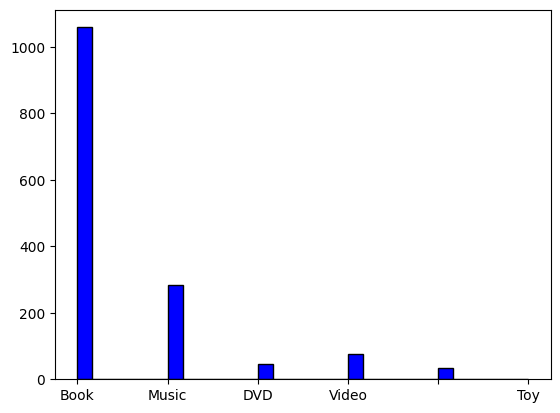

In [24]:
pandas_df = metadf.select('groups').toPandas()
plt.hist(pandas_df['groups'], color='blue', edgecolor='black', bins=int(30/1))
# plt.hist(newdf['avg_rating'], color='blue', edgecolor='black', bins=int(45/1))
ax.set_ylabel('Frequency of groups')


Text(0.5, 0, 'Total Frequency')

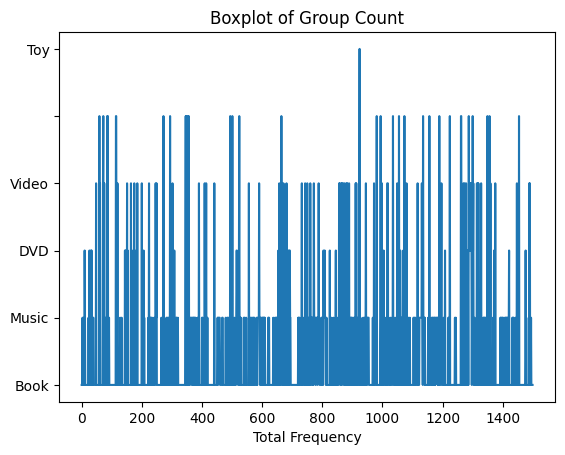

In [21]:
fig, ax = plt.subplots()
ax.plot(pandas_df['groups'])
ax.set_title('Boxplot of Group Count')
ax.set_xlabel('Total Frequency')